In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
def read_data(path, filename):
    return pd.read_csv(os.path.join(path, filename), index_col=0)

In [3]:
df = read_data('archive/A_DeviceMotion_data/A_DeviceMotion_data/dws_1/', 'sub_1.csv')
df.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


In [4]:
def produce_magnitude(df, column):
    df[column+'.mag'] = np.sqrt(df[column+'.x']**2 + df[column+'.y']**2 + df[column+'.z']**2)

produce_magnitude(df, 'userAcceleration')
produce_magnitude(df, 'rotationRate')
df.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,userAcceleration.mag,rotationRate.mag
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,0.513360,1.370498
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,0.250235,1.141648
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,0.215450,0.372530
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,0.166728,1.049628
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,0.408720,0.921229


In [6]:
import numpy as np
import pandas as pd

def get_ds_infos():
    """
    Read the file includes data subject information.
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains inforamtion about data subjects' attributes 
    """ 

    dss = pd.read_csv("archive/data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset.
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])
    print(dt_list)
    return dt_list


def creat_time_series(folder_name, dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    Args:
        folder_name: one of 'A_DeviceMotion_data', 'B_Accelerometer_data', or C_Gyroscope_data
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be 'raw' which means you want raw data
        for every dimention of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be 'mag' which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeld dataset. False, if we only want sensor values.

    Returns:
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = folder_name+'/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data), dtype=int)
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset
#________________________________


ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

In [7]:
sdt = ["rotationRate", "userAcceleration"]
print("Selected sensor data types:\n" + str(sdt))
dt_list = set_data_types(sdt)
print("\nSelected columns from dataset:\n" + str(dt_list))

Selected sensor data types:
['rotationRate', 'userAcceleration']
[['rotationRate.x', 'rotationRate.y', 'rotationRate.z'], ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']]

Selected columns from dataset:
[['rotationRate.x', 'rotationRate.y', 'rotationRate.z'], ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']]


In [8]:
ACT_LABELS = ["sit", "std", "dws", "ups", "wlk", "jog"]
act_labels = ACT_LABELS [0:6]  # all activities
print("Selected activites: " + str(act_labels))  

Selected activites: ['sit', 'std', 'dws', 'ups', 'wlk', 'jog']


In [9]:
TRIAL_CODES = {
    ACT_LABELS[0]:[5],
    ACT_LABELS[1]:[6],
    ACT_LABELS[2]:[1],
    ACT_LABELS[3]:[3],
    ACT_LABELS[4]:[7],
    ACT_LABELS[5]:[9],
}
trial_codes = [TRIAL_CODES[act] for act in act_labels]
print("[INFO] -- Selected trials: " + str(trial_codes))

[INFO] -- Selected trials: [[5], [6], [1], [3], [7], [9]]


In [11]:
print("Loading...")
dataset = creat_time_series("archive/A_DeviceMotion_data/A_DeviceMotion_data", dt_list, act_labels, trial_codes, mode="mag", labeled=True)
print("Finished!")
df=dataset

Loading...
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series


ValueError: Shape of passed values is (830895, 6), indices imply (830895, 2)

In [ ]:
df.describe()

In [ ]:
df.to_csv('test.csv')

In [12]:
plt.rcParams['figure.figsize'] = (30,8)
plt.rcParams['font.size'] = 32
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
clr1 = ["rs-","r*-","ro-","rv-","rp-","r^-"]
clr2 = ["bs-","b*-","bo-","bv-","bp-","b^-"]
act_lbl = ["Sat", "Stand-Up", "Downstairs", "Upstairs", "Walking", "Jogging"]
lbl = ["rotation", "acceleration"]

In [13]:
period = 2.5 # Seconds
sample_rate = 50 # Hz
points = int(period*sample_rate)
x_ticks = np.arange(0.,points/sample_rate,1./sample_rate)
print("Data points per time-series: " + str(points))

Data points per time-series: 125


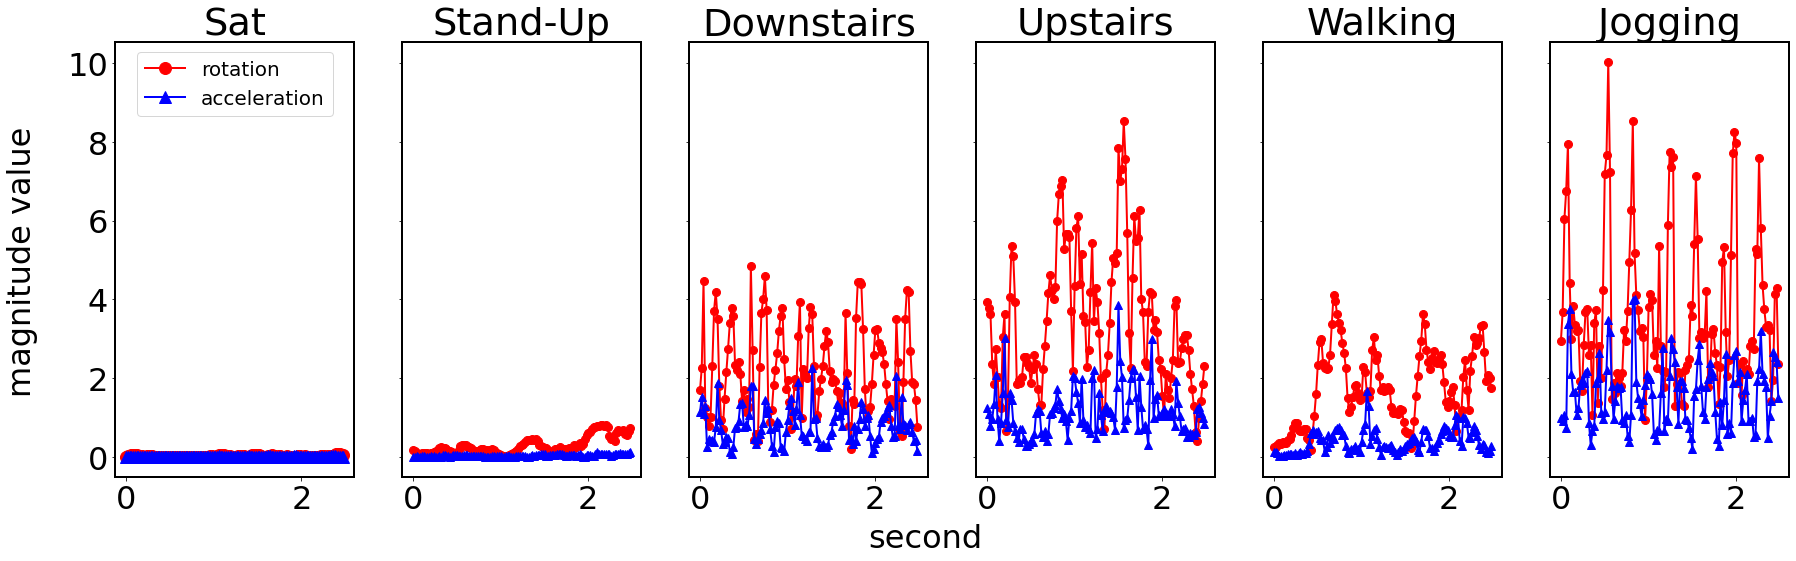

In [14]:
act_data = np.zeros((6,points))
fig, ax = plt.subplots(1, 6, sharex='col', sharey='row')
uid = 12 # We have 24 users in the dataset, uid can be selected from {0,1,...23}
for i in np.unique(dataset["act"]):
    i =int(i)
    data = dataset[(dataset["id"] == uid) & (dataset["act"] == i)]
    acc = data["userAcceleration"].values
    rot = data["rotationRate"].values
    acc = acc[:points]
    rot = rot[:points]
    
    if i!=0:
        ax[i].plot(x_ticks, rot, "ro-", linewidth=2, markersize=8)
        ax[i].plot(x_ticks, acc, "b^-", linewidth=2, markersize=8)
    else:
        ax[i].plot(x_ticks, rot, "ro-", linewidth=2, markersize=12, label=lbl[0])
        ax[i].plot(x_ticks, acc, "b^-", linewidth=2, markersize=12, label=lbl[1])

    ax[i].set_title(act_lbl[i])
plt.setp(ax, yticks=np.arange(0, 11, 2))
fig.text(0.5, 0.004, 'second', ha='center')
fig.text(0.075, 0.5, 'magnitude value', va='center', rotation='vertical', )
ax[0].legend(loc="upper center", fontsize = 20)

In [15]:
from sklearn.model_selection import train_test_split

Y = df['act']
X = df[['rotationRate', 'userAcceleration', 'weight', 'height', 'age', 'gender']]


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=52)

print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of Y_train:', Y_train.shape)
print('Shape of Y_test:', Y_test.shape)

Shape of X_train: (664716, 6)
Shape of X_test: (166179, 6)
Shape of Y_train: (664716,)
Shape of Y_test: (166179,)


In [16]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)

In [17]:
model.fit(X_train, Y_train)

RandomForestClassifier()

In [21]:
import joblib

# Save the model as a pickle in a file
joblib.dump(model, 'ftest_mag.pkl')

['ftest_mag.pkl']

In [22]:
# Load the model from the file
knn_from_joblib = joblib.load('ftest_mag.pkl') 
  
# Use the loaded model to make predictions
knn_from_joblib.predict(X_test)

MemoryError: Unable to allocate 12.4 MiB for an array with shape (1630662,) and data type float64

In [18]:
yhat = model.predict(X_test)
yhat

array([1., 5., 5., ..., 1., 4., 4.])

In [19]:
from sklearn.metrics import classification_report
target_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']

print(classification_report(Y_test, yhat, target_names=target_names))

                    precision    recall  f1-score   support

           Walking       0.83      0.81      0.82     46770
  Walking Upstairs       0.80      0.83      0.81     44994
Walking Downstairs       0.26      0.17      0.20      9988
           Sitting       0.35      0.27      0.31     11700
          Standing       0.58      0.69      0.63     31753
            Laying       0.71      0.71      0.71     20974

          accuracy                           0.70    166179
         macro avg       0.59      0.58      0.58    166179
      weighted avg       0.69      0.70      0.69    166179

